Reference: https://colab.research.google.com/github/ampl/colab.ampl.com/blob/master/authors/lentz/gcg/cpmp.ipynb

In [1]:
%pip install -q amplpy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.6/5.6 MB 10.9 MB/s eta 0:00:00


In [22]:
import networkx as nx
import matplotlib.pyplot as plt
from amplpy import AMPL, ampl_notebook

ampl = ampl_notebook(
    modules=["gcg"],  # modules to install
    license_uuid="default",  # license to use
)

Using default Community Edition License for Colab. Get yours at: https://ampl.com/ce
Licensed to AMPL Community Edition License for the AMPL Model Colaboratory (https://colab.ampl.com).


# Problem

The goal of the capacitated $p$-median problem (CPMP) is to fix $p \in \mathbb{N}$ locations as medians from a given number of $n \in \mathbb{N}$ locations. Furthermore, we are given demands $q_{i} \geq 0$ and capacities $Q_{i} \geq 0$ for every location $i \in \{1,\ldots,n\}$ as well as distances $d_{ij} \geq 0$ for each pair of locations $i,j \in \{1,\ldots,n\}$. While fixing the medians, we also assign every location $i \in \{1,\ldots,n\}$ to exactly one median such that the demands of all locations assigned to the median can be satisfied by the capacity of the median. An assignment of locations to a median is called a cluster. The overall objective is to minimize the total distance between the medians and their assigned locations.

$$
\begin{aligned}
\text{minimize} \quad &\sum_{i = 1}^{n} \sum_{j = 1}^{n} d_{i j}  x_{i j} \\
\text{subject to} \quad &\sum_{j = 1}^{n} x_{i j} = 1 \quad \forall i \in \{1,...,n\} \\
&\sum_{i = 1}^{n} q_{i} x_{i j} \leq Q_{j} y_{j} \quad \forall j \in \{1,...,n\} \\
&\sum_{j = 1}^{n} y_{j} = p \\
&x_{i j}, y_j \in \{0,1\} \quad \forall i,j \in \{1,...,n\}
\end{aligned}
$$

In [23]:
%%ampl_eval
param n;
param p;

set I = 1..n ordered;
set J = 1..n ordered;

param d {I,J};
param w {I};
param C {J};

var x {I,J} binary;
var y {J} binary;

minimize Cost:  sum {i in I} sum {j in J} d[i,j] * x[i,j];

subject to Allocate {i in I}:
   sum {j in J} x[i,j] = 1;

subject to Capacity {j in J}:
   sum {i in I} w[i] * x[i,j] <= C[j] * y[j];

subject to NFacilities:
  sum{j in J} y[j] <= p;

In [24]:
ampl.param["n"] = 5
ampl.param["p"] = 2

d = [
    [0, 6, 54, 52, 19],
    [6, 0, 28, 75, 61],
    [54, 28, 0, 91, 40],
    [52, 75, 91, 0, 28],
    [19, 61, 40, 28, 0],
]
ampl.param["d"] = {(i, j): d[i - 1][j - 1] for i in range(1, 6) for j in range(1, 6)}

ampl.param["w"] = [14, 13, 9, 15, 6]
ampl.param["C"] = [39, 39, 39, 39, 39]

In [25]:
ampl.option["solver"] = "gcg"
ampl.option["gcg_options"] = "outlev=1"
ampl.solve()

GCG 3.6.0:   tech:outlev = 1
presolving:
(round 1, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 10 upgd conss, 0 impls, 5 clqs
(round 2, exhaustive) 0 del vars, 0 del conss, 0 add conss, 0 chg bounds, 0 chg sides, 0 chg coeffs, 11 upgd conss, 0 impls, 30 clqs
   (0.0s) probing cycle finished: starting next cycle
presolving (3 rounds: 3 fast, 3 medium, 3 exhaustive):
 0 deleted vars, 0 deleted constraints, 0 added constraints, 0 tightened bounds, 0 added holes, 0 changed sides, 0 changed coefficients
 0 implications, 30 cliques
presolved problem has 30 variables (30 bin, 0 int, 0 impl, 0 cont) and 11 constraints
      6 constraints of type <knapsack>
      5 constraints of type <setppc>
transformed objective value is always integral (scale: 1)
Presolving Time: 0.00
 Consclassifier "nonzeros" yields a classification with 2  different constraint classes 
 Consclassifier "constypes" yields a classification with 2 different constraint classes 
 

In [26]:
ampl.display("x")

x [*,*]
:   1   2   3   4   5    :=
1   0   1   0   0   0
2   0   1   0   0   0
3   0   1   0   0   0
4   0   0   0   0   1
5   0   0   0   0   1
;



In [27]:
ampl.display("y")

y [*] :=
1  0
2  1
3  0
4  0
5  1
;



This allows self-loops.

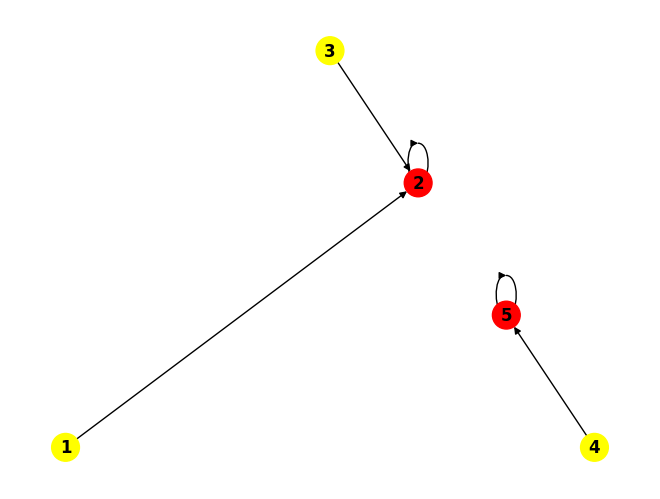

In [32]:
g = nx.DiGraph()
g.add_weighted_edges_from([
    (1, 2, 6),
    (2, 2, 0),
    (3, 2, 28),
    (4, 5, 28),
    (5, 5, 0)
])

color_map = ['yellow']*5
color_map[1] = 'red'
color_map[4] = 'red'

options = {
    'node_color': color_map,
    'node_size': 400,
    'width': 1,
    'font_weight': 'bold',
    'with_labels': True
}
nx.draw(g, pos=nx.planar_layout(g), **options)